In [150]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import ray
from ray import tune
from ray.rllib.agents.ppo import PPOAgent
from neurocuts_env import NeuroCutsEnv
from run_neurocuts import on_episode_end
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from mask import PartitionMaskModel

%matplotlib inline

In [111]:
### Init ###
rules = os.path.abspath("classbench/{}".format("acl5_1k"))
dump_dir = "/tmp/neurocuts_out"
reward_shape = "linear"

ray.init()

2019-03-05 18:02:27,148	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-03-05_18-02-27_39290/logs.
2019-03-05 18:02:27,148	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-03-05_18-02-27_39290/logs.
2019-03-05 18:02:27,148	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-03-05_18-02-27_39290/logs.
2019-03-05 18:02:27,267	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:49464 to respond...
2019-03-05 18:02:27,267	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:49464 to respond...
2019-03-05 18:02:27,267	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:49464 to respond...
2019-03-05 18:02:27,390	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:19190 to respond...
2019-03-05 18:02:27,390	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:19190 to respond...
2019-03-05 18:02:27,390	INFO services.py:396


View the web UI at http://localhost:8895/notebooks/ray_ui.ipynb?token=3637bb6dc2b9541ac294a7a7c7327bd587b00d1dcbca0b85



{'node_ip_address': None,
 'redis_address': '192.168.0.101:49464',
 'object_store_address': '/tmp/ray/session_2019-03-05_18-02-27_39290/sockets/plasma_store',
 'webui_url': 'http://localhost:8895/notebooks/ray_ui.ipynb?token=3637bb6dc2b9541ac294a7a7c7327bd587b00d1dcbca0b85',
 'raylet_socket_name': '/tmp/ray/session_2019-03-05_18-02-27_39290/sockets/raylet'}

In [112]:
### Setup ###
register_env(
    "tree_env", lambda env_config: NeuroCutsEnv(
        env_config["rules"],
        max_depth=env_config["max_depth"],
        max_actions_per_episode=env_config["max_actions"],
        dump_dir=env_config["dump_dir"],
        depth_weight=env_config["depth_weight"],
        reward_shape=env_config["reward_shape"],
        partition_mode=env_config["partition_mode"]))
ModelCatalog.register_custom_model("mask", PartitionMaskModel)

config =  {
        "num_gpus": 0,
        "num_workers": 3,
        "sgd_minibatch_size": 100,
        "sample_batch_size": 200,
        "train_batch_size": 1000,
        "batch_mode": "complete_episodes",
        "observation_filter": "NoFilter",
        "model": {
            "custom_model": "mask",
            "fcnet_hiddens": [512, 512],
        },
        "vf_share_layers": True,
        "entropy_coeff": 0.01,
        "callbacks": {
            "on_episode_end": tune.function(on_episode_end),
        },
        "env_config": {
            "dump_dir": dump_dir,
            "partition_mode": None,
            "reward_shape": reward_shape,
            "max_depth": 100,
            "max_actions": 1000,
            "depth_weight": 1.0,
            "rules": rules,
        },
    }

In [147]:
file = "/Users/yitianzou/ray_results/neurocuts_None/PPO_tree_env_1_rules=_Users_yitianzou_neurocuts-code_classbench_acl5_1k,sample_batch_size=400_2019-02-20_15-30-42uewkqv_l/checkpoint_1/checkpoint-1"
env = NeuroCutsEnv(rules_file="classbench/acl5_1k")
agent = PPOAgent(env="tree_env", config=config)
agent.restore(file)

2019-03-05 18:22:50,506	INFO policy_evaluator.py:264 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2019-03-05 18:22:51,366	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']


In [134]:
### Load obs ###
path = "obs1.json"
obs_dict = {}

with open(path, 'r') as f:
    key = f.readline().rstrip()
    obs = f.readline().rstrip()
    act = f.readline().rstrip()

    while key:
        dict_ = {"real_obs": json.loads(obs), "action_mask": json.loads(act)}
        obs_dict[json.loads(key)] = dict_
        key = f.readline().rstrip()
        obs = f.readline().rstrip()
        act = f.readline().rstrip()
print(len(obs_dict))

1000


In [312]:
### Extract variables ###
keys = list(obs_dict.keys())

src = []
dst = []
values = []
for key, obs in obs_dict.items():
    src_ip = obs["real_obs"][:32]
    dst_ip = obs["real_obs"][32:64]
    _obs = agent.local_evaluator.preprocessors["default"].transform(obs)
    value = agent.get_policy()._value(_obs)
    src.append(src_ip)
    dst.append(dst_ip)
    values.append(value)
values = np.array(values)
print(len(values))

1000


In [313]:
### Extract IP addresses ###
def extract_address(ip):
    ip_str = ''.join(str(int(e)) for e in ip)
    ip_dec = int(ip_str, 2)
    return ip_dec
src_ip = np.array([extract_address(ip) for ip in src])
dst_ip = np.array([extract_address(ip) for ip in dst])

In [333]:
### Stats ###
x_min = np.min(src_ip)
x_max = np.max(src_ip)
x_med = np.median(src_ip)
x_unique = len(np.unique(src_ip))
y_min = np.min(dst_ip)
y_max = np.max(dst_ip)
y_med = np.median(dst_ip)
y_unique = len(np.unique(dst_ip))

print("Src ip has min {}, max {}, median {}, and {} unique elements".format(x_min, x_max, x_med, x_unique))
print("Dst ip has min {}, max {}, median {}, and {} unique elements".format(y_min, y_max, y_med, y_unique))

Src ip has min 0, max 1930976512, median 127374147.0, and 44 unique elements
Dst ip has min 47400581, max 2147483647, median 134217727.0, and 50 unique elements


0.9038722248354003
0.9666830994758807
0.09510682356658329


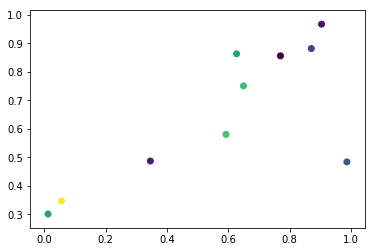

In [317]:
### Scatter example ###
N = 10
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
alpha = 0.5
# plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.scatter(x, y, c=colors)
print(x[0])
print(y[0])
print(colors[0])

/Users/yitianzou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/yitianzou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0,0.5,'Dst ip')

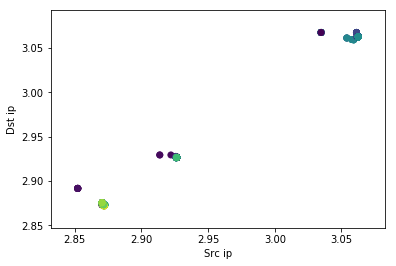

In [336]:
### Scatter plot ###
_src_ip = np.log(np.log(src_ip))
_dst_ip = np.log(np.log(dst_ip))
plt.scatter(_src_ip, _dst_ip, c=values)
plt.xlabel("Src ip")
plt.ylabel("Dst ip")
# Yellow = high
# Green = medium
# Blue = low

(12,)
(8,)
(8, 12)


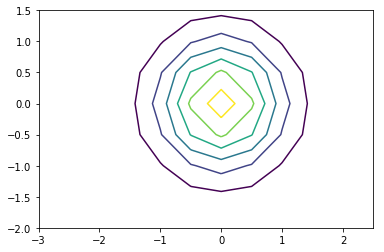

In [233]:
### Contour example ###
delta = 0.5
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z = np.exp(-X**2 - Y**2)
print(x.shape)
print(y.shape)
print(Z.shape)
plt.contour(X, Y, Z)

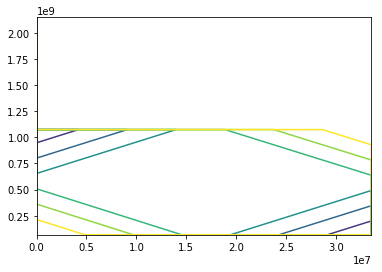

In [245]:
### Plot 1 point ###
x = _src_ip
y = _dst_ip
X, Y = np.meshgrid(x, y)
Z = np.diag(values)
plt.contour(X, Y, Z)
# Yellow = high
# Green = medium
# Blue = low